<a href="https://colab.research.google.com/github/nattntn/7-14yrs_EffNet/blob/main/Transfer_with_Age%20%20/%20Train%20/%207_14_01_Eff_Regress_Train_250Freeze_Unflipped.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#เรียกใช้ CSV

In [ ]:
import pandas as pd
import shutil

In [ ]:
#เชื่อม google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Imports

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline
import datetime

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

#กำหนดค่าพารามิเตอร์


In [ ]:
batch_size = 16
width = 224 # จตุรัส โมเตลจะเรียนรู้ภาพได้ดีที่สุด
height = 224
epochs = 250 # รอบในการเทรน
dropout_rate = 0.2
input_shape = (height, width, 3)

#Clone efficientnet repo


In [ ]:
#ดึงข้อมูลใน Github มาใช้
import os
%cd /content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
 !git clone https://github.com/Wanita-8943/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/


/content
Cloning into 'efficientnet_keras_transfer_learning'...
remote: Enumerating objects: 1100, done.
remote: Counting objects: 100% (263/263), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 1100 (delta 133), reused 241 (delta 121), pack-reused 837
Receiving objects: 100% (1100/1100), 14.10 MiB | 17.23 MiB/s, done.
Resolving deltas: 100% (630/630), done.
/content/efficientnet_keras_transfer_learning


In [ ]:
# Options: EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
# Higher the number, the more complex the model is.
from efficientnet import EfficientNetB0 as Net
from efficientnet import center_crop_and_resize, preprocess_input

In [ ]:
# loading pretrained conv base model
# โหลดโมเดล มาโดยตัด output ของโมเดลออก เเต่ยังใช้ input อันเดิม
# เเละโหลด weight ของโมเดล มาด้วยที่ชื่อว่า imagenet
conv_base = Net(weights='imagenet', include_top=False, input_shape=input_shape) # convolution base = base ที่เอาไว้เรียนแบบยังไม่ปรับ

16717576/16717576 [==============================] - 0s 0us/step


In [ ]:
conv_base.summary() #ดู Summary

Model: "efficientnet-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 swish (Swish)               (None, 112, 112, 32)         0         ['batch_normaliz

In [ ]:
# ฟังก์ชัน ReLU ทำการปรับค่า x โดยให้เป็น 0 หาก x น้อยกว่า 0 และให้เป็น  x หาก x มากกว่าหรือเท่ากับ 0 นั่นหมายความว่า ReLU จะ "กระตุ้น" ค่าที่มากกว่าหรือเท่ากับ 0 ให้ผ่านไป และจะปรับค่าที่น้อยกว่า 0 เป็น 0 นั่นเอง

In [ ]:
x = conv_base.output
### add the tail layer ###
Flatten_layer1 = layers.Flatten()(x)
BatchNormalization_layer1 = layers.BatchNormalization(name='BatchNormalization_1')(Flatten_layer1)
Dense_layer1 = layers.Dense(64, activation='relu',name='Dense_layer1')(BatchNormalization_layer1)
BatchNormalization_layer2 = layers.BatchNormalization(name='BatchNormalization_2')(Dense_layer1)
prediction_age = layers.Dense(1, activation='linear',name='prediction_age')(BatchNormalization_layer2)

In [ ]:
### lastlayer
model = models.Model(inputs= conv_base.input, outputs=prediction_age, name = 'EffNet_Regression')

In [ ]:
print('This is the number of trainable layers '
      'of the conv base:', len(conv_base.trainable_weights))

print('This is the number of trainable layers '
      'of the model:', len(model.trainable_weights))

This is the number of trainable layers of the conv base: 211
This is the number of trainable layers of the model: 219


In [ ]:
model.summary() #ดู Summary

Model: "EffNet_Regression"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 swish (Swish)               (None, 112, 112, 32)         0         ['batch_normal

In [ ]:
##Freeze
print('This is the number of trainable layers '
          'before freezing the conv base:', len(model.trainable_weights))
for layer in conv_base.layers:
    layer.trainable = False
print('This is the number of trainable layers '
          'after freezing the conv base:', len(model.trainable_weights))
print('-'*80)
model.summary()

This is the number of trainable layers before freezing the conv base: 219
This is the number of trainable layers after freezing the conv base: 8
--------------------------------------------------------------------------------
Model: "EffNet_Regression"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 32)         128       ['conv2d[0][0]']              
 Normalization)                                       

#สร้างโฟลเดอร์ Train Valodation และ Test

In [ ]:
df = pd.read_csv (r'/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_tooth/Model/Unflipped_Regress_Age(7-14)/table_train_7_14_fold.csv')
df

,Unnamed: 0,Age(year),Gender,Folder_type,Folder_name,Path_Name,Filename,Fold
0,0,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V1.jpg,2
1,1,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV1.jpg,4
2,2,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V2.jpg,10
3,3,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV2.jpg,9
4,4,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V3.jpg,10
...,...,...,...,...,...,...,...,...
1828,1828,14,M,Normal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,YY69.jpg,6
1829,1829,14,M,Normal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,Y231.jpg,9
1830,1830,14,M,Normal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,Y286.jpg,1
1831,1831,14,M,Normal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,Y309.jpg,3


In [ ]:
df = df.iloc[:,1:]

In [ ]:
# train7_14 = df[(df['Age(year)']>= 7)&(df['Age(year)']<= 14)]
# train7_14

In [ ]:
# train7_14.to_csv('/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_tooth/Model/Unflipped_Regress_Age(7-23)/table_train_7_14_fold.csv') #save ลงไดร์ฟ

In [ ]:
val = df[df['Fold']==3]
val

,Age(year),Gender,Folder_type,Folder_name,Path_Name,Filename,Fold
6,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V6.jpg,3
20,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V26.jpg,3
38,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V43.jpg,3
43,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV52.jpg,3
51,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV56.jpg,3
...,...,...,...,...,...,...,...
1774,14,M,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipY205.jpg,3
1793,14,M,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,Y314.jpg,3
1796,14,M,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipY319.jpg,3
1808,14,M,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipY340.jpg,3


In [ ]:
train = df[~df['Fold'].isin(val['Fold'])]
train

,Age(year),Gender,Folder_type,Folder_name,Path_Name,Filename,Fold
0,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V1.jpg,2
1,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV1.jpg,4
2,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V2.jpg,10
3,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV2.jpg,9
4,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V3.jpg,10
...,...,...,...,...,...,...,...
1827,14,M,Normal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,YY16.jpg,4
1828,14,M,Normal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,YY69.jpg,6
1829,14,M,Normal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,Y231.jpg,9
1830,14,M,Normal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,Y286.jpg,1


In [ ]:
DATA_PATH = "/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_tooth/Data_Cut_images/Normal"
os.chdir(DATA_PATH)
#train_dir = os.path.join(DATA_PATH, 'train')
#print(train_dir)
#validation_dir = os.path.join(DATA_PATH, 'validation')
#print(validation_dir)


#Train

In [ ]:
# Train ด้วย ImageDataGenerator ของ Keras ซึ่งจะเพิ่มข้อมูลเสริมระหว่างการฝึกเพื่อลดโอกาสเกิด overfitting
#overfitting เกิดจากข้อมูลที่ซับซ้อนกันเกินไป
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255, #โมเดลส่วนใหญ่ต้องใช้ RGB ในช่วง 0–1
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      # horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
        dataframe = train,
        directory = DATA_PATH,
        x_col = 'Path_Name',
        y_col = 'Age(year)',
        class_mode = 'raw',
        color_mode= 'rgb',
        target_size=(height, width),
        batch_size=batch_size)

validation_generator = test_datagen.flow_from_dataframe(
        dataframe = val,
        directory = DATA_PATH,
        x_col = 'Path_Name',
        y_col = 'Age(year)',
        class_mode = 'raw',
        color_mode= 'rgb',
        target_size=(height, width),
        batch_size=batch_size)

Found 1651 validated image filenames.
Found 182 validated image filenames.


In [ ]:
model.compile(loss='mse',
          optimizer=Adam(learning_rate=1e-4),
          metrics=['mse'])

In [ ]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch= len(train) //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= len(val) //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

<ipython-input-24-4a1ce764999b>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/250
103/103 [==============================] - 170s 1s/step - loss: 111.4952 - mse: 111.4952 - val_loss: 130.8448 - val_mse: 130.8448
Epoch 2/250
103/103 [==============================] - 14s 135ms/step - loss: 108.3341 - mse: 108.3341 - val_loss: 113.6872 - val_mse: 113.6872
Epoch 3/250
103/103 [==============================] - 15s 140ms/step - loss: 105.5820 - mse: 105.5820 - val_loss: 105.7307 - val_mse: 105.7307
Epoch 4/250
103/103 [==============================] - 14s 133ms/step - loss: 102.9591 - mse: 102.9591 - val_loss: 110.5742 - val_mse: 110.5742
Epoch 5/250
103/103 [==============================] - 15s 138ms/step - loss: 99.6962 - mse: 99.6962 - val_loss: 107.5309 - val_mse: 107.5309
Epoch 6/250
103/103 [==============================] - 14s 134ms/step - loss: 96.0514 - mse: 96.0514 - val_loss: 102.6190 - val_mse: 102.6190
Epoch 7/250
103/103 [==============================] - 10s 90ms/step - loss: 92.6559 - mse: 92.6559 - val_loss: 102.7150 - val_mse: 102.7150
E

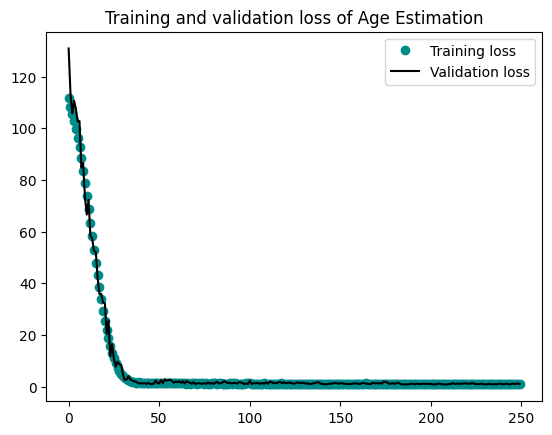

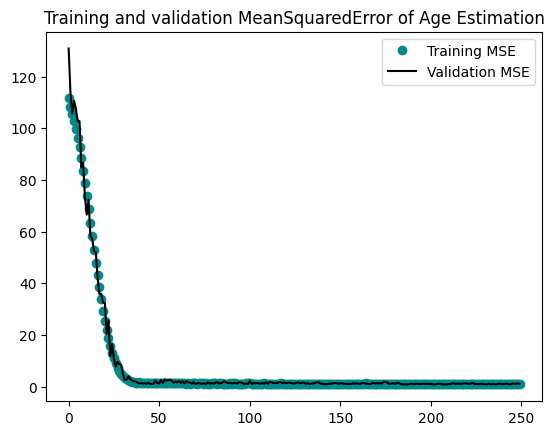

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
mse = history.history['mse']
val_mse = history.history['val_mse']


epochs_x = range(len(loss))


# plt.plot(epochs_x, loss, 'go', label='Training loss')
plt.plot(epochs_x, loss, 'o', color ='darkcyan', label='Training loss')
plt.plot(epochs_x, val_loss, 'k', label='Validation loss')
plt.title('Training and validation loss of Age Estimation')
plt.legend()

plt.figure()
# plt.plot(epochs_x, mse, 'go', label='Training MSE')
plt.plot(epochs_x, mse, 'o', color ='darkcyan', label='Training MSE')
plt.plot(epochs_x, val_mse, 'k', label='Validation MSE')
plt.title('Training and validation MeanSquaredError of Age Estimation')
plt.legend()



plt.show()

In [ ]:
epochs_x

range(0, 250)

#Download the model


In [ ]:
os.makedirs('/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_tooth/Model', exist_ok=True)
model.save('/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_tooth/Model/Unflipped_Regress_Age(7-14)/1_Re_1e-4_250_Freeze.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
